In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

# own imports
import sys
sys.path.append("../")

# setup GPU
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
print(device)

# autoreload
%load_ext autoreload
%autoreload 2

cuda:0


# Implementations

### Implement computation of filterbank matrices

In [3]:
def compute_filterbank(A, B, log_var, gt_X, gt_Y, log_dt, N):
    """ Compute the two filterbank matrices

    Input
        log_var :   The log of the variance.
        gt_X    :   Used to calculate center X coordinate.
        gt_Y    :   Used to calculate center Y coordinate.
        log_dt  :   Used to calculate the stride.
        N       :   Number of points in the patch in each dimension.

    Return
        F_X     :   Horizontal filterbank matrix of size (N, A)
        F_Y     :   Vertical filterbank matrix of size (N, B)
    """ 

    # retrieve non-log versions
    var = np.exp(log_var + 1e-8)

    # calculate grid center
    g_X = (A + 1) * (gt_X + 1) / 2
    g_Y = (B + 1) * (gt_Y + 1) / 2

    # calculate stride
    d = np.exp(log_dt) * (np.max([A, B]) - 1) / (N - 1)
    
    # compute filters
    F_X = np.zeros((N, A))
    F_Y = np.zeros((N, B))

    # construct mean vectors
    mu_X = np.linspace(
        g_X + (- N/2 - 0.5) * d, 
        g_X + (N-1 - N/2 - 0.5) * d,
        N
    )
    mu_Y = np.linspace(
        g_Y + (- N/2 - 0.5) * d, 
        g_Y + (N-1 - N/2 - 0.5) * d,
        N
    )
    
    # Compute filter matrices
    for a in range(A):
        F_X[:, a] = np.exp( -(a - mu_X)**2 / (2 * var))

    for b in range(B):
        F_Y[:, b] = np.exp( -(b - mu_Y)**2 / (2 * var))

    # normalize filters (should each sum to 1)
    F_X = F_X / np.sum(F_X)
    F_Y = F_Y / np.sum(F_Y)
    
    # get 'legal' indices range
    x_range = [
        int(np.max([0, mu_X[0]])), 
        int(np.min([A, mu_X[N-1]]))
    ]
    y_range = [
        int(np.max([0, mu_Y[0]])),
        int(np.min([B, mu_Y[N-1]]))
    ]

    # crop filters to fit image
    F_X = F_X[:, x_range[0]:x_range[1]]
    F_Y = F_Y[:, y_range[0]:y_range[1]]

    return F_X, F_Y, x_range, y_range

### Function to crop image
Crops image to fit the allowable range

In [4]:
def crop_img(img, xr, yr):
    return img[yr[0]:yr[1], xr[0]:xr[1]]

### Function to apply filters to the cropped image

In [23]:
def filter_img(img, F_X, F_Y, log_gamma):
    return np.exp(log_gamma) * F_Y @ img @ F_X.T

# Load image data (MNIST)

In [6]:
# define lambda func
def tmp_lambda(x):
    return torch.bernoulli(x)

# load / download the data
BATCH_SIZE = 64
mnist_data = MNIST(
    './', 
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(tmp_lambda)
    ])
)

kwargs = {'num_workers': 2, 'pin_memory': True} if cuda else {}
data_loader = DataLoader(
    mnist_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    **kwargs
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


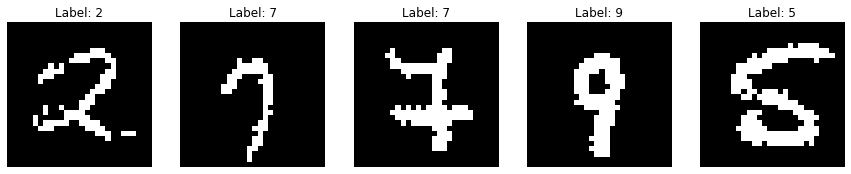

In [7]:
# Plot a few samples
data_iter = iter(data_loader)
images, labels = data_iter.next()

N = 5
f, ax = plt.subplots(1, N, figsize=(3*N, 6))
for i in range(N):
    ax[i].imshow(images[i, 0], cmap='gray')
    ax[i].set_title(f'Label: {labels[i]}')
    ax[i].axis('off')
plt.show()

# Inspect effects of Filterbank matrices

### Plot functions

In [30]:
def plot_filterbanks(F_X, F_Y):
    f, ax = plt.subplots(1, 2)
    ax[0].imshow(F_X, cmap='gray')
    ax[0].set_title('Filter X')
    ax[0].set_xlabel('i')
    ax[0].set_ylabel('a')
    ax[1].imshow(F_Y, cmap='gray')
    ax[1].set_title('Filter Y')
    ax[1].set_xlabel('j')
    ax[1].set_ylabel('b')
    plt.show()

def plot_filteredimg(img, F_X, F_Y, log_gamma, title="Filtered image"):
    f, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Patch of image')
    ax[0].axis('off')
    ax[1].imshow(filter_img(img, F_X, F_Y, log_gamma), cmap='gray')
    ax[1].set_title(title)
    ax[1].axis('off')
    plt.show()

### ff

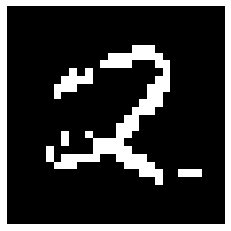

In [31]:
# Pick a single image
img = images[0].numpy()[0]
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [32]:
# Define parameters
A = 28
B = 28
N = 10    # resolution of filters
gt_X = 0  # x-focus
gt_Y = 0  # y-focus

log_dt = -0.001
log_var = [5, 1, -1, -5]
log_g = [5, 1, -1, -5]

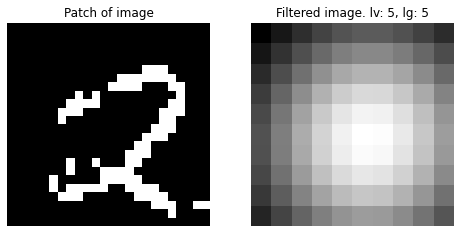

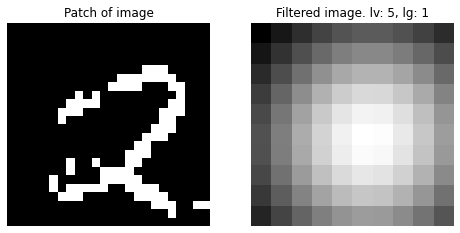

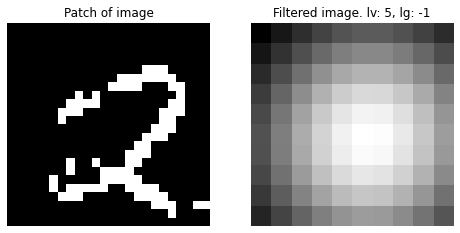

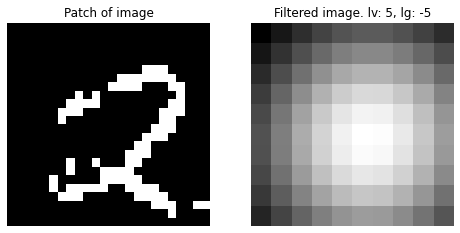

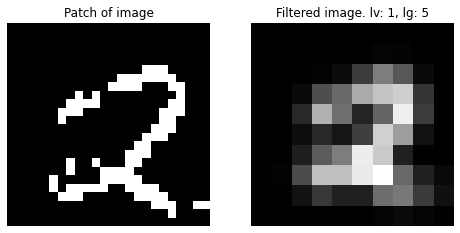

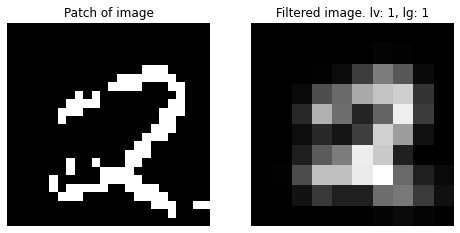

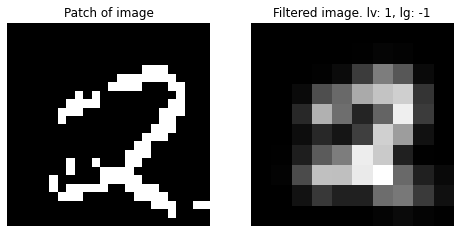

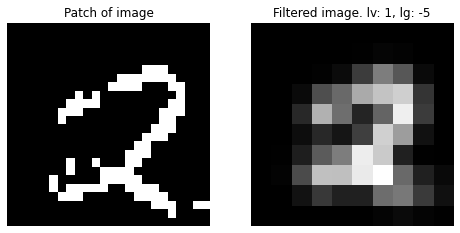

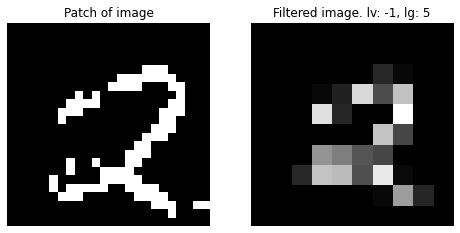

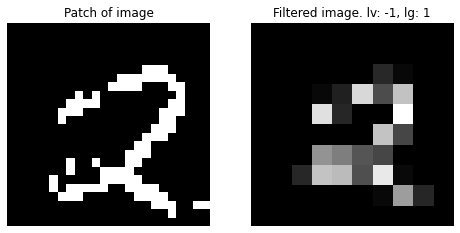

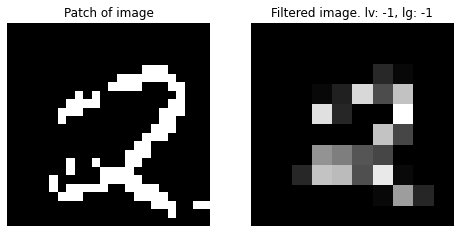

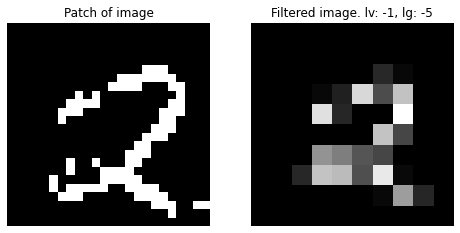

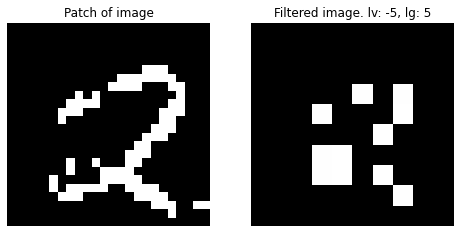

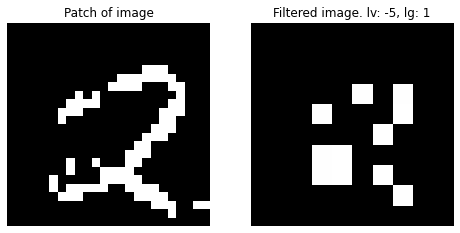

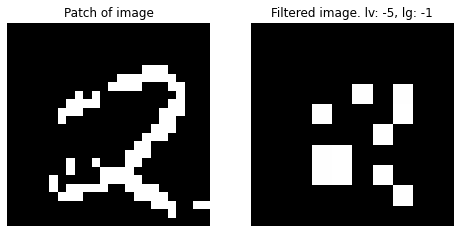

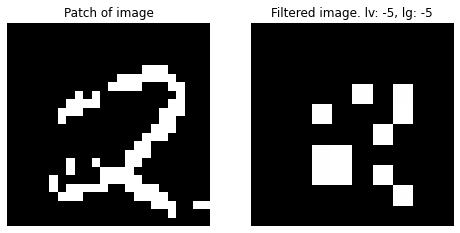

In [34]:
# Iterate over 
for lv in log_var:
    for lg in log_g:
        title = f"Filtered image. lv: {lv}, lg: {lg}"
        F_X, F_Y, xr, yr = compute_filterbank(A, B, lv, gt_X, gt_Y, log_dt, N)
        img_focus = crop_img(img, xr, yr)
        # plot_filterbanks(F_X, F_Y)
        plot_filteredimg(img_focus, F_X, F_Y, lg, title)